# FFT on time series data

Using the article from:

https://bugra.github.io/work/notes/2014-03-31/outlier-detection-in-time-series-signals-fft-median-filtering/

Should make this work on the existing data under data/ in the future.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import random
import pandas as pd
%matplotlib inline

In [2]:
# Signal parameters
number_of_samples  = 1000
frequency_of_signal = 5
sample_time = 0.001
amplitude = 1
#Noise parameters
mu = 0
sigma = 1

signal = [amplitude * np.sin((2 * np.pi) * frequency_of_signal * ii * sample_time) for ii in range(number_of_samples)]
s_time = [ii * sample_time for ii in range(number_of_samples)]
noise = [random.gauss(mu, sigma) for _ in range(number_of_samples)]
signal_with_noise = [ii + jj for ii, jj in zip(signal, noise)]

In [3]:
# Skip this, just playing with data frames
df = pd.DataFrame([signal,s_time]).transpose()
df.columns = ['signal', 'time']

#or zip

df2 = pd.DataFrame(zip(signal, s_time), columns=['signal', 's_time'])
df2.head()

,signal,s_time
0,0.000000,0.000
1,0.031411,0.001
2,0.062791,0.002
3,0.094108,0.003
4,0.125333,0.004


Text(0.5, 1.0, 'Original Signal')

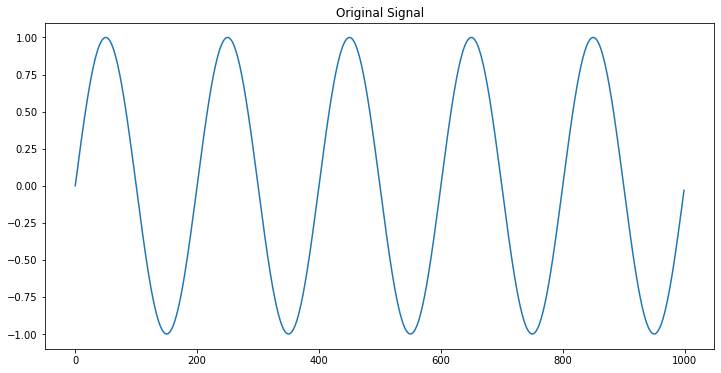

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(signal)
plt.title('Original Signal')

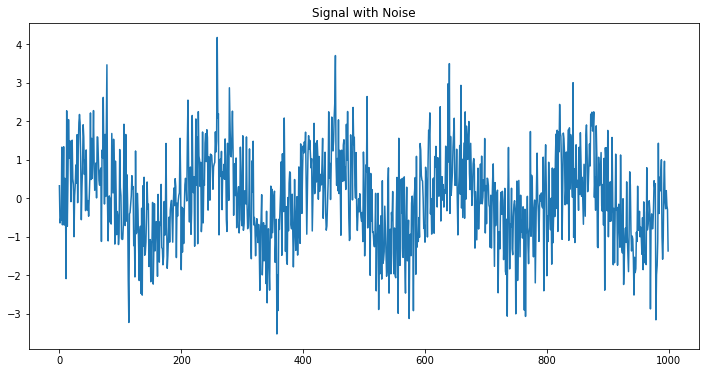

In [5]:
plt.figure(figsize=(12, 6));
plt.plot(signal_with_noise);
plt.title('Signal with Noise');

In [6]:
fft_of_signal_with_noise = np.fft.fft(signal_with_noise)
f = np.fft.fftfreq(len(fft_of_signal_with_noise),sample_time)
# IMPORTANT! Absolute number of a complex number (that is likely to come out of FFT) is:
#  | a + bi | = SQRT(a^2 + b^2)
# which gets us out of the complex  number domain!
fft_data = pd.DataFrame(zip(fft_of_signal_with_noise, abs(fft_of_signal_with_noise), f), columns=['fft', 'fft_abs','fft_freq'])  
fft_data

#
# Also equally interesting:
# By looking at the fft absolute values, you see how well the input signal correlates with 
# a the underlying signal at fft_freq. Below, you'll find that the fft_freq == frequency_of_signal
# has the maximum correlation. 

# https://math.stackexchange.com/questions/414365/how-to-interpret-fourier-transform-result
# "The result of the Fourier Transform as you will exercise from my above description 
#  will bring you only knowledge about the frequency composition of your data sequences."

#
# Also interesting, for real valued inputs, the FFT results is symetrical, so you can use the
# first half of the results to identify predominant frequencies. 
# https://stackoverflow.com/questions/4364823/how-do-i-obtain-the-frequencies-of-each-value-in-an-fft
# "Note that for a real input signal (imaginary parts all zero) the second half of the FFT 
#  (bins from N / 2 + 1 to N - 1) contain no useful additional information"

,fft,fft_abs,fft_freq
0,-8.591673+0.000000j,8.591673,0.0
1,-11.200790-15.430735j,19.067387,1.0
2,-12.078929+29.050100j,31.461228,2.0
3,18.403720-16.410586j,24.657742,3.0
4,-3.124162+7.767073j,8.371847,4.0
...,...,...,...
995,10.512837+477.002459j,477.118293,-5.0
996,-3.124162-7.767073j,8.371847,-4.0
997,18.403720+16.410586j,24.657742,-3.0
998,-12.078929-29.050100j,31.461228,-2.0


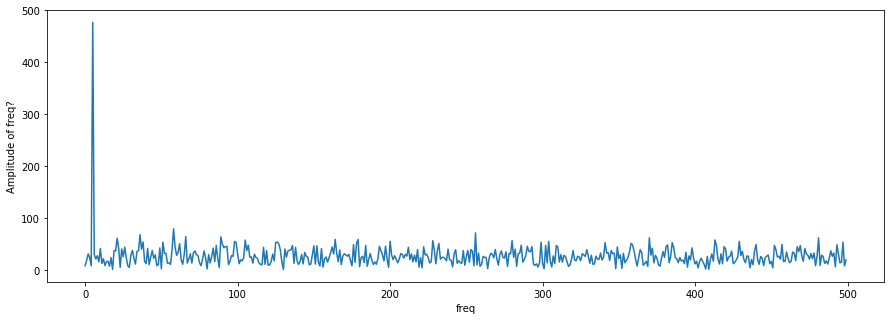

In [10]:
N = df.shape[0]
plt.figure(figsize=(15,5))
plt.plot(fft_data.fft_freq[0:int(N/2)], fft_data.fft_abs[0:int(N/2)])
plt.xlabel('freq')
plt.ylabel('Amplitude of freq?')
plt.show()

In [12]:
print(f.shape)
print(len(signal_with_noise))
print(fft_of_signal_with_noise.shape)

(1000,)
1000
(1000,)


In [18]:
def determine_top_frequencies(fft_data, coverage=0.9):
    (nrow, ncol) = fft_data.shape
    N = int(nrow/2)
    df = fft_data.iloc[0:N,:]
    df2 = df.sort_values(by=['fft_abs'], ascending=False)
    freqs = []
    for i in range(0,N):
        cur_fft = df2.fft_abs.iloc[i]
        if len(freqs) == 0:
            freqs.append(df2.fft_freq.iloc[i])
        else:
            prev = df2.fft_abs.iloc[i-1]
            #print prev, cur_fft, (prev / cur_fft)
            if (prev / cur_fft) > 5:
                break
            else:
                freqs.append(cur_fft_freq)
    return freqs
        

In [19]:
target_freq = determine_top_frequencies(fft_data)[0]
print(target_freq)

5.0


In [20]:
def bandpass_filter(x, freq, frequency_of_signal=frequency_of_signal, band = 0.05):
    if (frequency_of_signal - band) < abs(freq) < (frequency_of_signal + band):
        return x
    else:
        return 0

In [21]:
zip(fft_of_signal_with_noise, f)

In [22]:
F_filtered = np.asanyarray([bandpass_filter(x,freq, target_freq) for x,freq in zip(fft_of_signal_with_noise, f)])

In [24]:
reconstructed_filtered_signal = np.fft.ifft(F_filtered)
print(reconstructed_filtered_signal)

[ 0.02102567+0.00000000e+00j  0.05098132+5.68434189e-17j
  0.08088665-5.68434189e-17j  0.11071216+0.00000000e+00j
  0.1404284 +0.00000000e+00j  0.17000606+5.68434189e-17j
  0.19941595+5.68434189e-17j  0.22862903+0.00000000e+00j
  0.25761649+5.68434189e-17j  0.28634971+1.13686838e-16j
  0.31480034+0.00000000e+00j  0.3429403 +0.00000000e+00j
  0.37074181+0.00000000e+00j  0.39817745+5.68434189e-17j
  0.42522014+0.00000000e+00j  0.45184318-5.68434189e-17j
  0.47802031+5.68434189e-17j  0.5037257 +1.13686838e-16j
  0.52893396+0.00000000e+00j  0.55362023+1.13686838e-16j
  0.57776015+5.68434189e-17j  0.60132989+1.13686838e-16j
  0.62430618+1.13686838e-16j  0.64666636+0.00000000e+00j
  0.66838836+0.00000000e+00j  0.68945074+5.68434189e-17j
  0.70983272+0.00000000e+00j  0.72951418+5.68434189e-17j
  0.74847569-5.68434189e-17j  0.76669855+5.68434189e-17j
  0.78416477-5.68434189e-17j  0.80085712+0.00000000e+00j
  0.81675911-1.13686838e-16j  0.83185507+2.84217094e-17j
  0.84613008+0.00000000e+00j  0

/opt/anaconda2/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


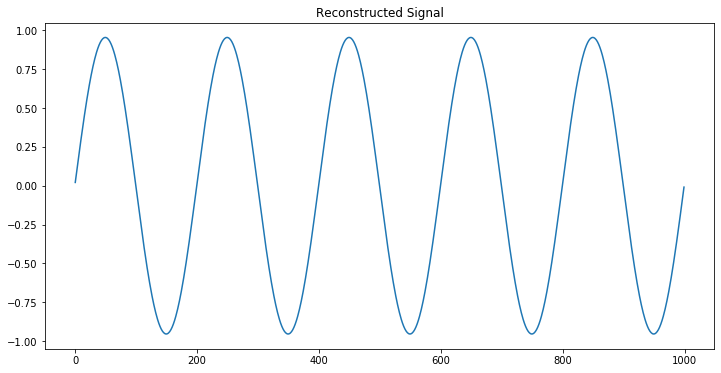

In [25]:
plt.figure(figsize=(12, 6));
plt.plot(reconstructed_filtered_signal);
plt.title('Reconstructed Signal');

In [26]:
a = 1
x = np.arange(1,50,.5)
y = np.sin(-1/x) * np.sin(x)

y_with_outlier = np.copy(y)

for ii in np.arange(len(x)/10, len(x), len(x)/10.):
    y_with_outlier[int(ii)]= 4*(random.random()-.5) + y[int(ii)]

Text(0, 0.5, 'Signal with outliers')

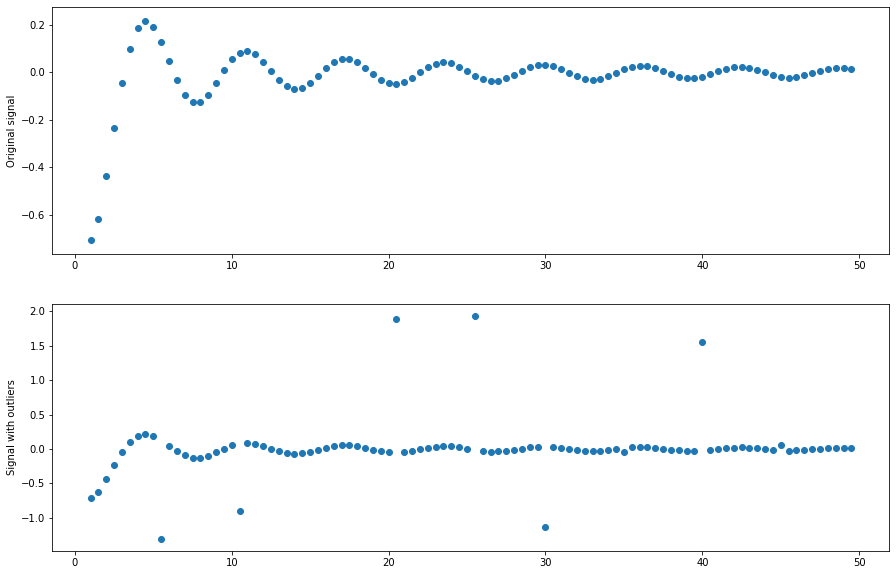

In [28]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.scatter(x, y)
plt.ylabel('Original signal')
plt.subplot(2,1,2)
plt.scatter(x, y_with_outlier)
plt.ylabel('Signal with outliers')

Text(0, 0.5, 'Amplitude of freq?')

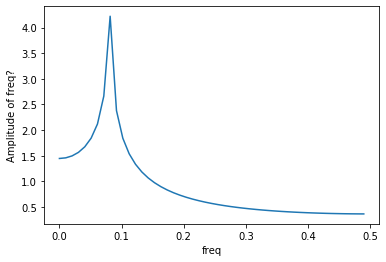

In [30]:
fft_y = np.fft.fft(y)
f_y = np.fft.fftfreq(len(fft_y))

N = fft_y.shape[0]
plt.figure()
plt.plot(f_y[0:int(N/2)], abs(fft_y[0:int(N/2)]))
plt.xlabel('freq')
plt.ylabel('Amplitude of freq?')


Text(0, 0.5, 'Original signal')

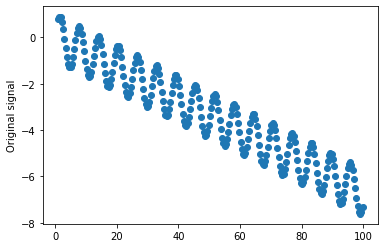

In [31]:
# Let's try another signal but with y values decreasing and the amplitude not decreasing as much
x = np.arange(1,100,.4)
y = np.sin(x) - x/15

plt.figure()
plt.scatter(x, y)
plt.ylabel('Original signal')

In [37]:
def plot_fft(y):
    fft_y = np.fft.fft(y)
    f_y = np.fft.fftfreq(len(fft_y))
    N = fft_y.shape[0]
    plt.figure()
    plt.plot(f_y[0:int(N/2)], abs(fft_y[0:int(N/2)]))
    plt.xlabel('freq')
    plt.ylabel('Amplitude of freq?')
    print(pd.DataFrame(zip(f_y[0:int(N/2)], abs(fft_y[0:N/2])), columns=['freq', 'amplitude']))

TypeError: slice indices must be integers or None or have an __index__ method

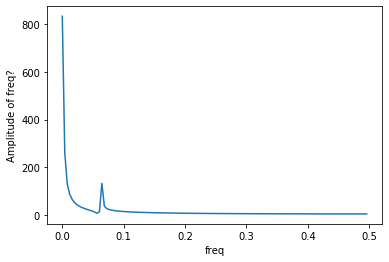

In [38]:
plot_fft(y)

# Peak at 0? That sounds weird!
 After reading this, realized that the signal we created breaks assumptions that FFT makes:
        https://www.mathworks.com/matlabcentral/answers/124471-fft-significant-peak-in-0-hz-component
 
**One of the basic assumptions is that that your data is a finite window sample of an infinitely periodic function.**

See an example of a de-trending...

https://www.mathworks.com/help/matlab/data_analysis/detrending-data.html



In [66]:
from scipy import signal
y_detrended = signal.detrend(y)

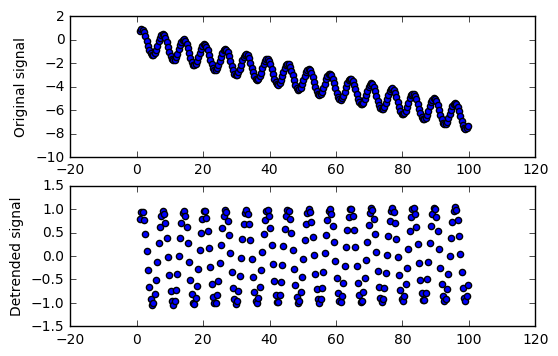

In [67]:
plt.figure()
plt.subplot(2,1,1)
plt.scatter(x, y)
plt.ylabel('Original signal')
plt.subplot(2,1,2)
plt.scatter(x, y_detrended)
plt.ylabel('Detrended signal')



         freq     amplitude
0    0.000000  2.593481e-13
1    0.004032  4.020573e+00
2    0.008065  2.332915e+00
3    0.012097  1.917304e+00
4    0.016129  1.829754e+00
5    0.020161  1.889492e+00
6    0.024194  2.044636e+00
7    0.028226  2.283010e+00
8    0.032258  2.612370e+00
9    0.036290  3.058087e+00
10   0.040323  3.670558e+00
11   0.044355  4.547112e+00
12   0.048387  5.891327e+00
13   0.052419  8.201660e+00
14   0.056452  1.309430e+01
15   0.060484  3.039163e+01
16   0.064516  1.155704e+02
17   0.068548  2.062609e+01
18   0.072581  1.152666e+01
19   0.076613  8.088837e+00
20   0.080645  6.279971e+00
21   0.084677  5.162462e+00
22   0.088710  4.402492e+00
23   0.092742  3.851406e+00
24   0.096774  3.432968e+00
25   0.100806  3.104049e+00
26   0.104839  2.838414e+00
27   0.108871  2.619190e+00
28   0.112903  2.435027e+00
29   0.116935  2.278013e+00
..        ...           ...
94   0.379032  6.248415e-01
95   0.383065  6.214231e-01
96   0.387097  6.181523e-01
97   0.391129  6.150

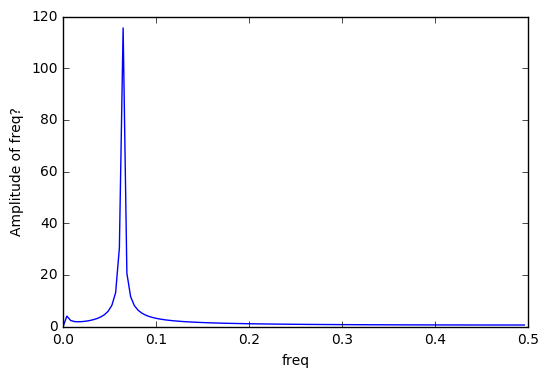

In [69]:
plot_fft(y_detrended)

Okay that makes more sense!